In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import dill
import warnings

import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from matplotlib import transforms

from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
# To Read out 1000 rows rather than the default value. 
pd.set_option('display.max_rows', 1000)

# To Read out 1000 columns rather than the default value. 
pd.set_option('display.max_columns', 1000)

# Not prinitng the warnings
warnings.filterwarnings('ignore')

# Setting the working directory for data and output files
cwd = os.getcwd()
os.chdir(cwd + '/data/')

# Setting a random seed for reproducability
np.random.seed(7)

# To make the plot output, appear and be stored within the notebook.
%matplotlib inline

# Setting the environment for temporary results
%env JOBLIB_TEMP_FOLDER = /tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [4]:
# Problem 1
df = pd.read_csv('kplr_dr25_inj1_plti.csv', header = 0)

print('Dataset Size:')
print(df.shape)
print()

temp_df = df.iloc[:, 0:15]
df_drop = temp_df[temp_df.isnull().any(axis=1)]
temp_df = temp_df.drop(df_drop.index.values)
print(temp_df.shape)

X = temp_df.iloc[:, 1:14]
Y = temp_df.iloc[:, 14]
cols_indices = X.columns

Dataset Size:
(146294, 25)

(146257, 15)


In [5]:
'''
# Problem 2
df = pd.read_csv('kplr_dr25_inj1_tces.csv', header = 0)

print('Dataset Size:')
print(df.shape)
print()

cols = ['TCE_ID', 'KIC', 'Disp', 'Score', 'period', 'epoch', 'NTL', 'SS', 
        'CO', 'EM', 'Expected_MES', 'MES', 'NTran', 'depth', 'duration', 'Rp',
        'Rs', 'Ts', 'logg', 'a', 'Rp/Rs', 'a/Rs', 'impact', 'SNR_DV', 'Sp',
        'Fit_Prov']
df = df[cols]
df.columns

df['Disp'] = df['Disp'].replace('PC', 1)
df['Disp'] = df['Disp'].replace('FP', 0)

X = df.iloc[:, 10:25]
Y = df.iloc[:, 2]
cols_indices = X.columns
'''

"\n# Problem 2\ndf = pd.read_csv('kplr_dr25_inj1_tces.csv', header = 0)\n\nprint('Dataset Size:')\nprint(df.shape)\nprint()\n\ncols = ['TCE_ID', 'KIC', 'Disp', 'Score', 'period', 'epoch', 'NTL', 'SS', \n        'CO', 'EM', 'Expected_MES', 'MES', 'NTran', 'depth', 'duration', 'Rp',\n        'Rs', 'Ts', 'logg', 'a', 'Rp/Rs', 'a/Rs', 'impact', 'SNR_DV', 'Sp',\n        'Fit_Prov']\ndf = df[cols]\ndf.columns\n\ndf['Disp'] = df['Disp'].replace('PC', 1)\ndf['Disp'] = df['Disp'].replace('FP', 0)\n\nX = df.iloc[:, 10:25]\nY = df.iloc[:, 2]\ncols_indices = X.columns\n"

In [6]:
# Build a forest and compute the feature importances
abc = AdaBoostClassifier()

abc.fit(X, Y)
abc_importances = abc.feature_importances_
abc_std = np.std([tree.feature_importances_ for tree in abc.estimators_], axis = 0)
abc_indices = np.argsort(abc_importances)[::-1]
abc_cols_indices = cols_indices[abc_indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, abc_cols_indices[f], abc_importances[abc_indices[f]]))

Feature ranking:
1. Expected_MES (0.320000)
2. i_dur (0.140000)
3. i_period (0.140000)
4. N_Transit (0.120000)
5. i_dor (0.080000)
6. i_ror (0.060000)
7. i_epoch (0.060000)
8. i_b (0.040000)
9. Sky_Group (0.040000)
10. Offset_distance (0.000000)
11. Offset_from_source (0.000000)
12. EB_injection (0.000000)
13. i_depth (0.000000)


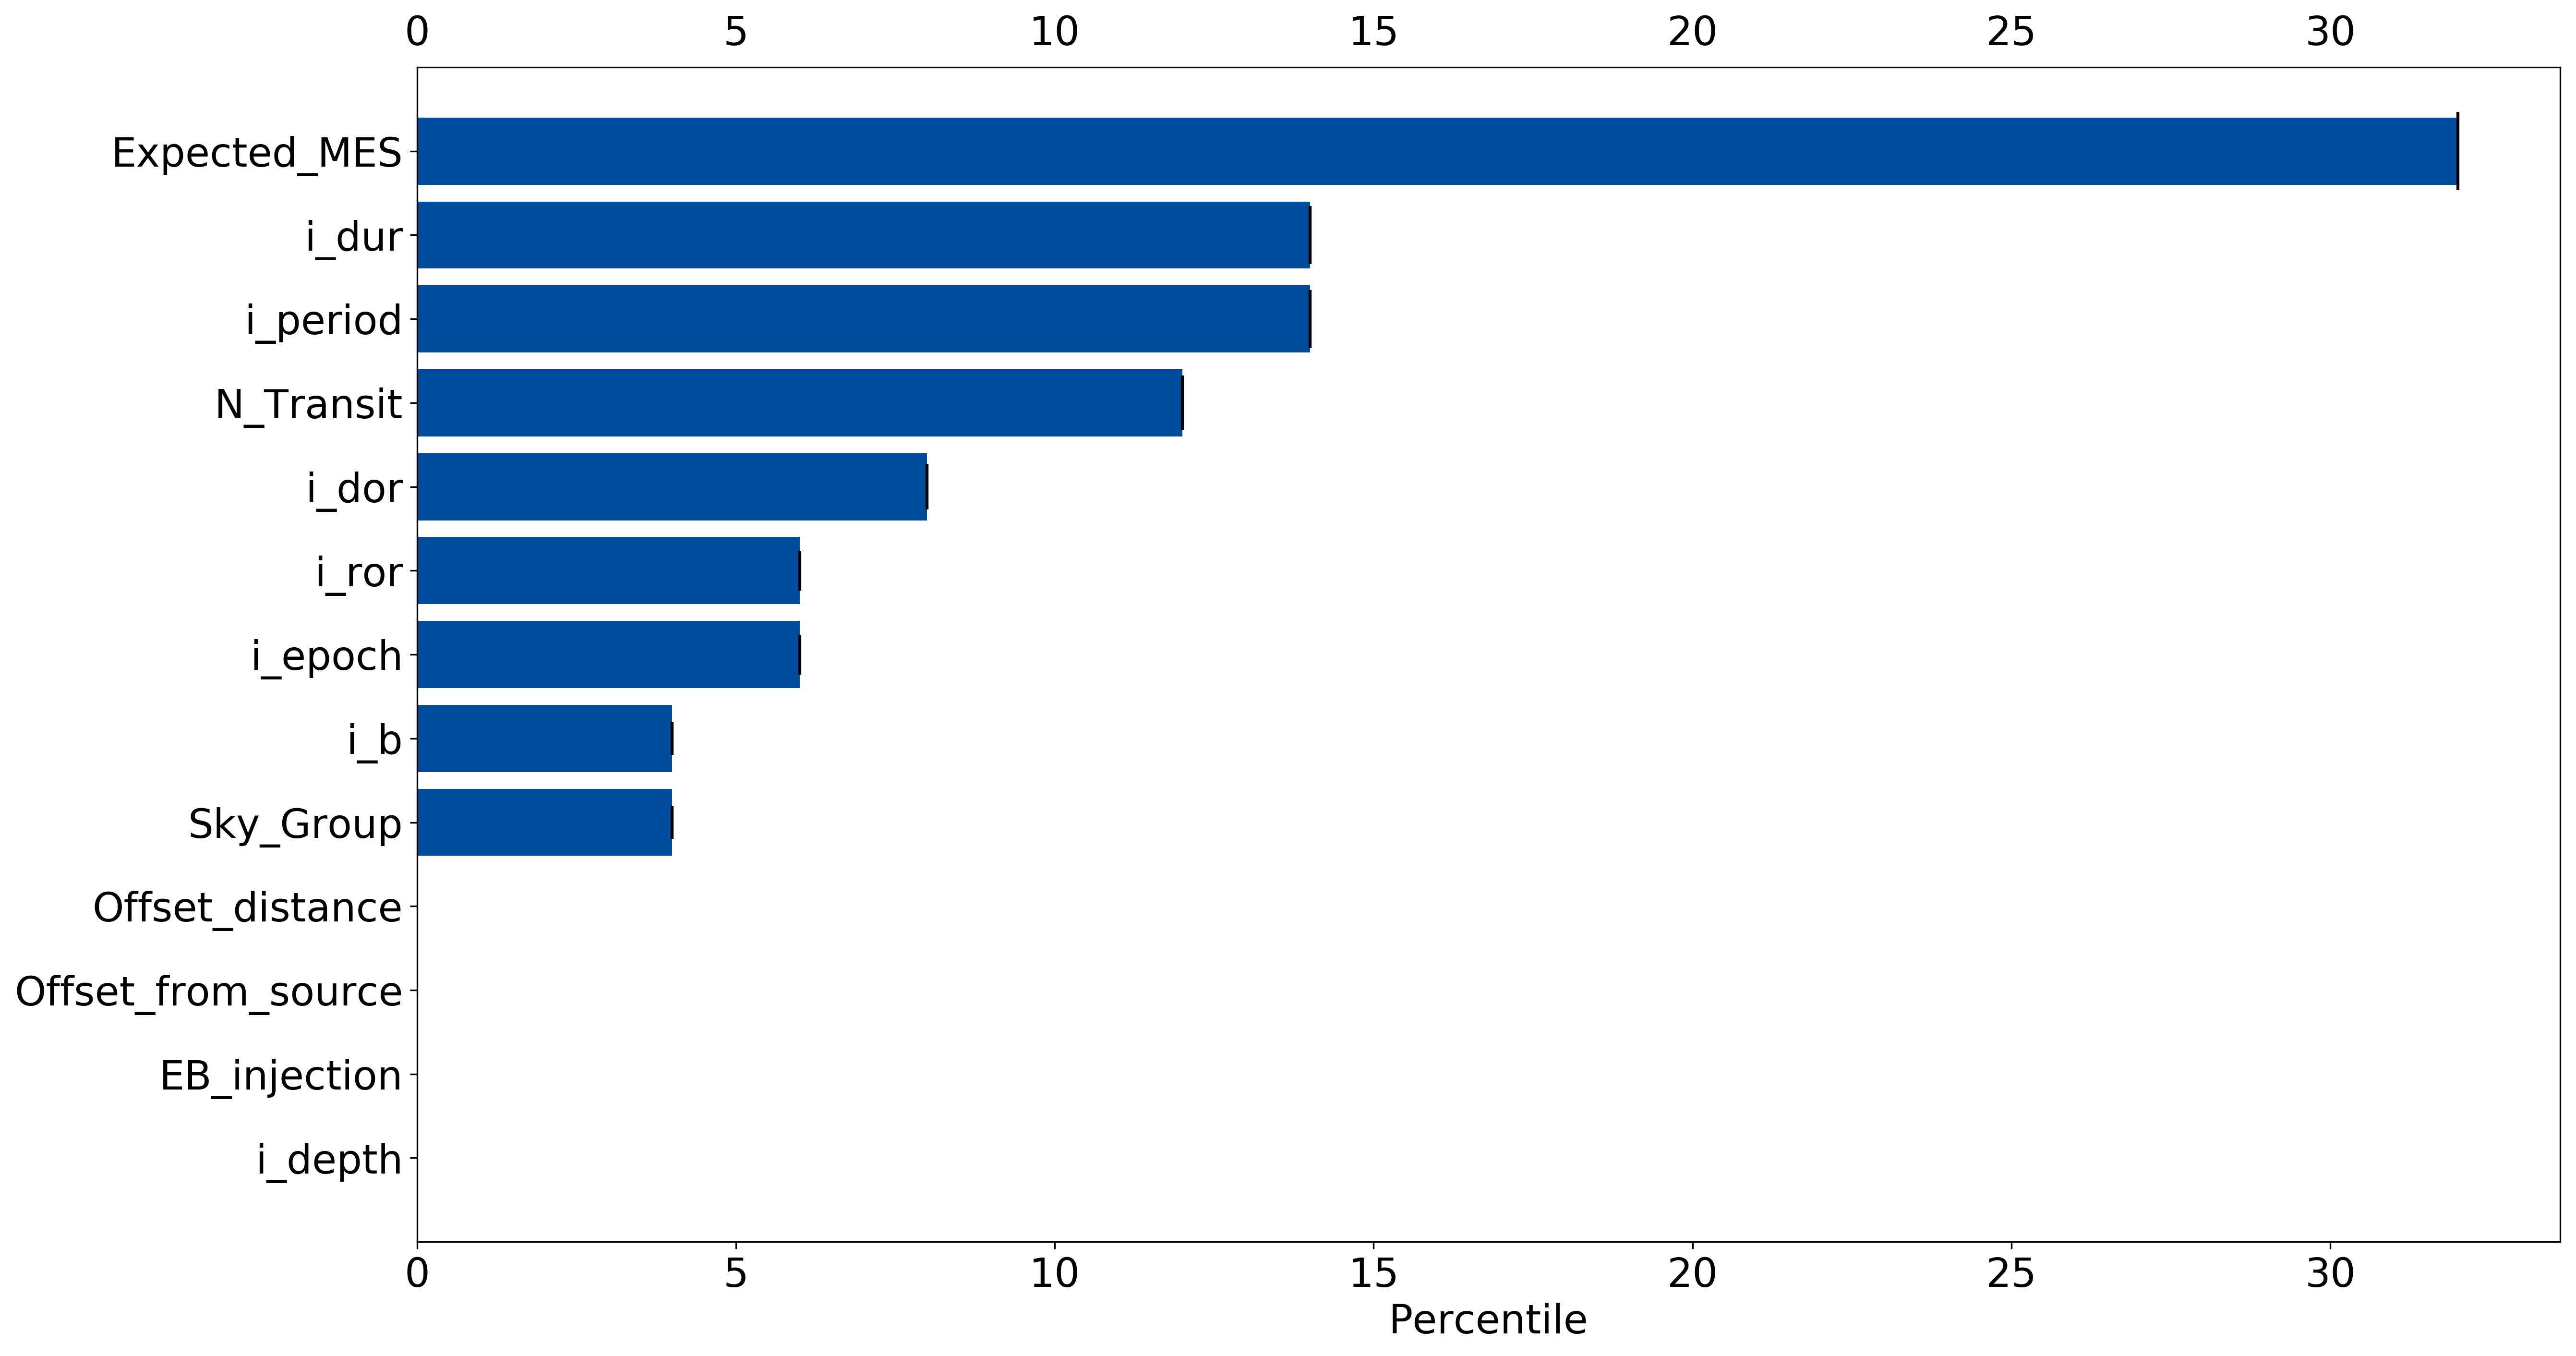

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot the feature importances of the forest
plt.figure(figsize = (19.20, 10.80), dpi = 300)
plt.tight_layout()
plt.barh(range(X.shape[1]), abc_importances[abc_indices]*100, color = '#004B9B', yerr=abc_std[abc_indices], align="center")

plt.yticks(range(X.shape[1]), abc_cols_indices, fontsize=20)
plt.ylim([X.shape[1], -1])
 
plt.tick_params(axis='x', labelbottom = True, labeltop = True)
plt.xticks(fontsize = 20)
plt.xlabel('Percentile', fontsize=20)

plt.savefig('full_dataset - ada_boost.jpg', dpi=1200, bbox_inches='tight')
plt.show()
plt.clf()

In [8]:
# Build a forest and compute the feature importances
etc = ExtraTreesClassifier(n_jobs = -1, verbose = 1)

etc.fit(X, Y)
etc_importances = etc.feature_importances_
etc_std = np.std([tree.feature_importances_ for tree in etc.estimators_], axis = 0)
etc_indices = np.argsort(etc_importances)[::-1]
etc_cols_indices = cols_indices[etc_indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, etc_cols_indices[f], etc_importances[etc_indices[f]]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Feature ranking:
1. Expected_MES (0.398118)
2. N_Transit (0.095044)
3. i_dur (0.081134)
4. i_dor (0.071773)
5. i_b (0.070637)
6. i_ror (0.065556)
7. i_depth (0.061048)
8. i_period (0.058125)
9. i_epoch (0.052352)
10. Sky_Group (0.046214)
11. Offset_distance (0.000000)
12. Offset_from_source (0.000000)
13. EB_injection (0.000000)


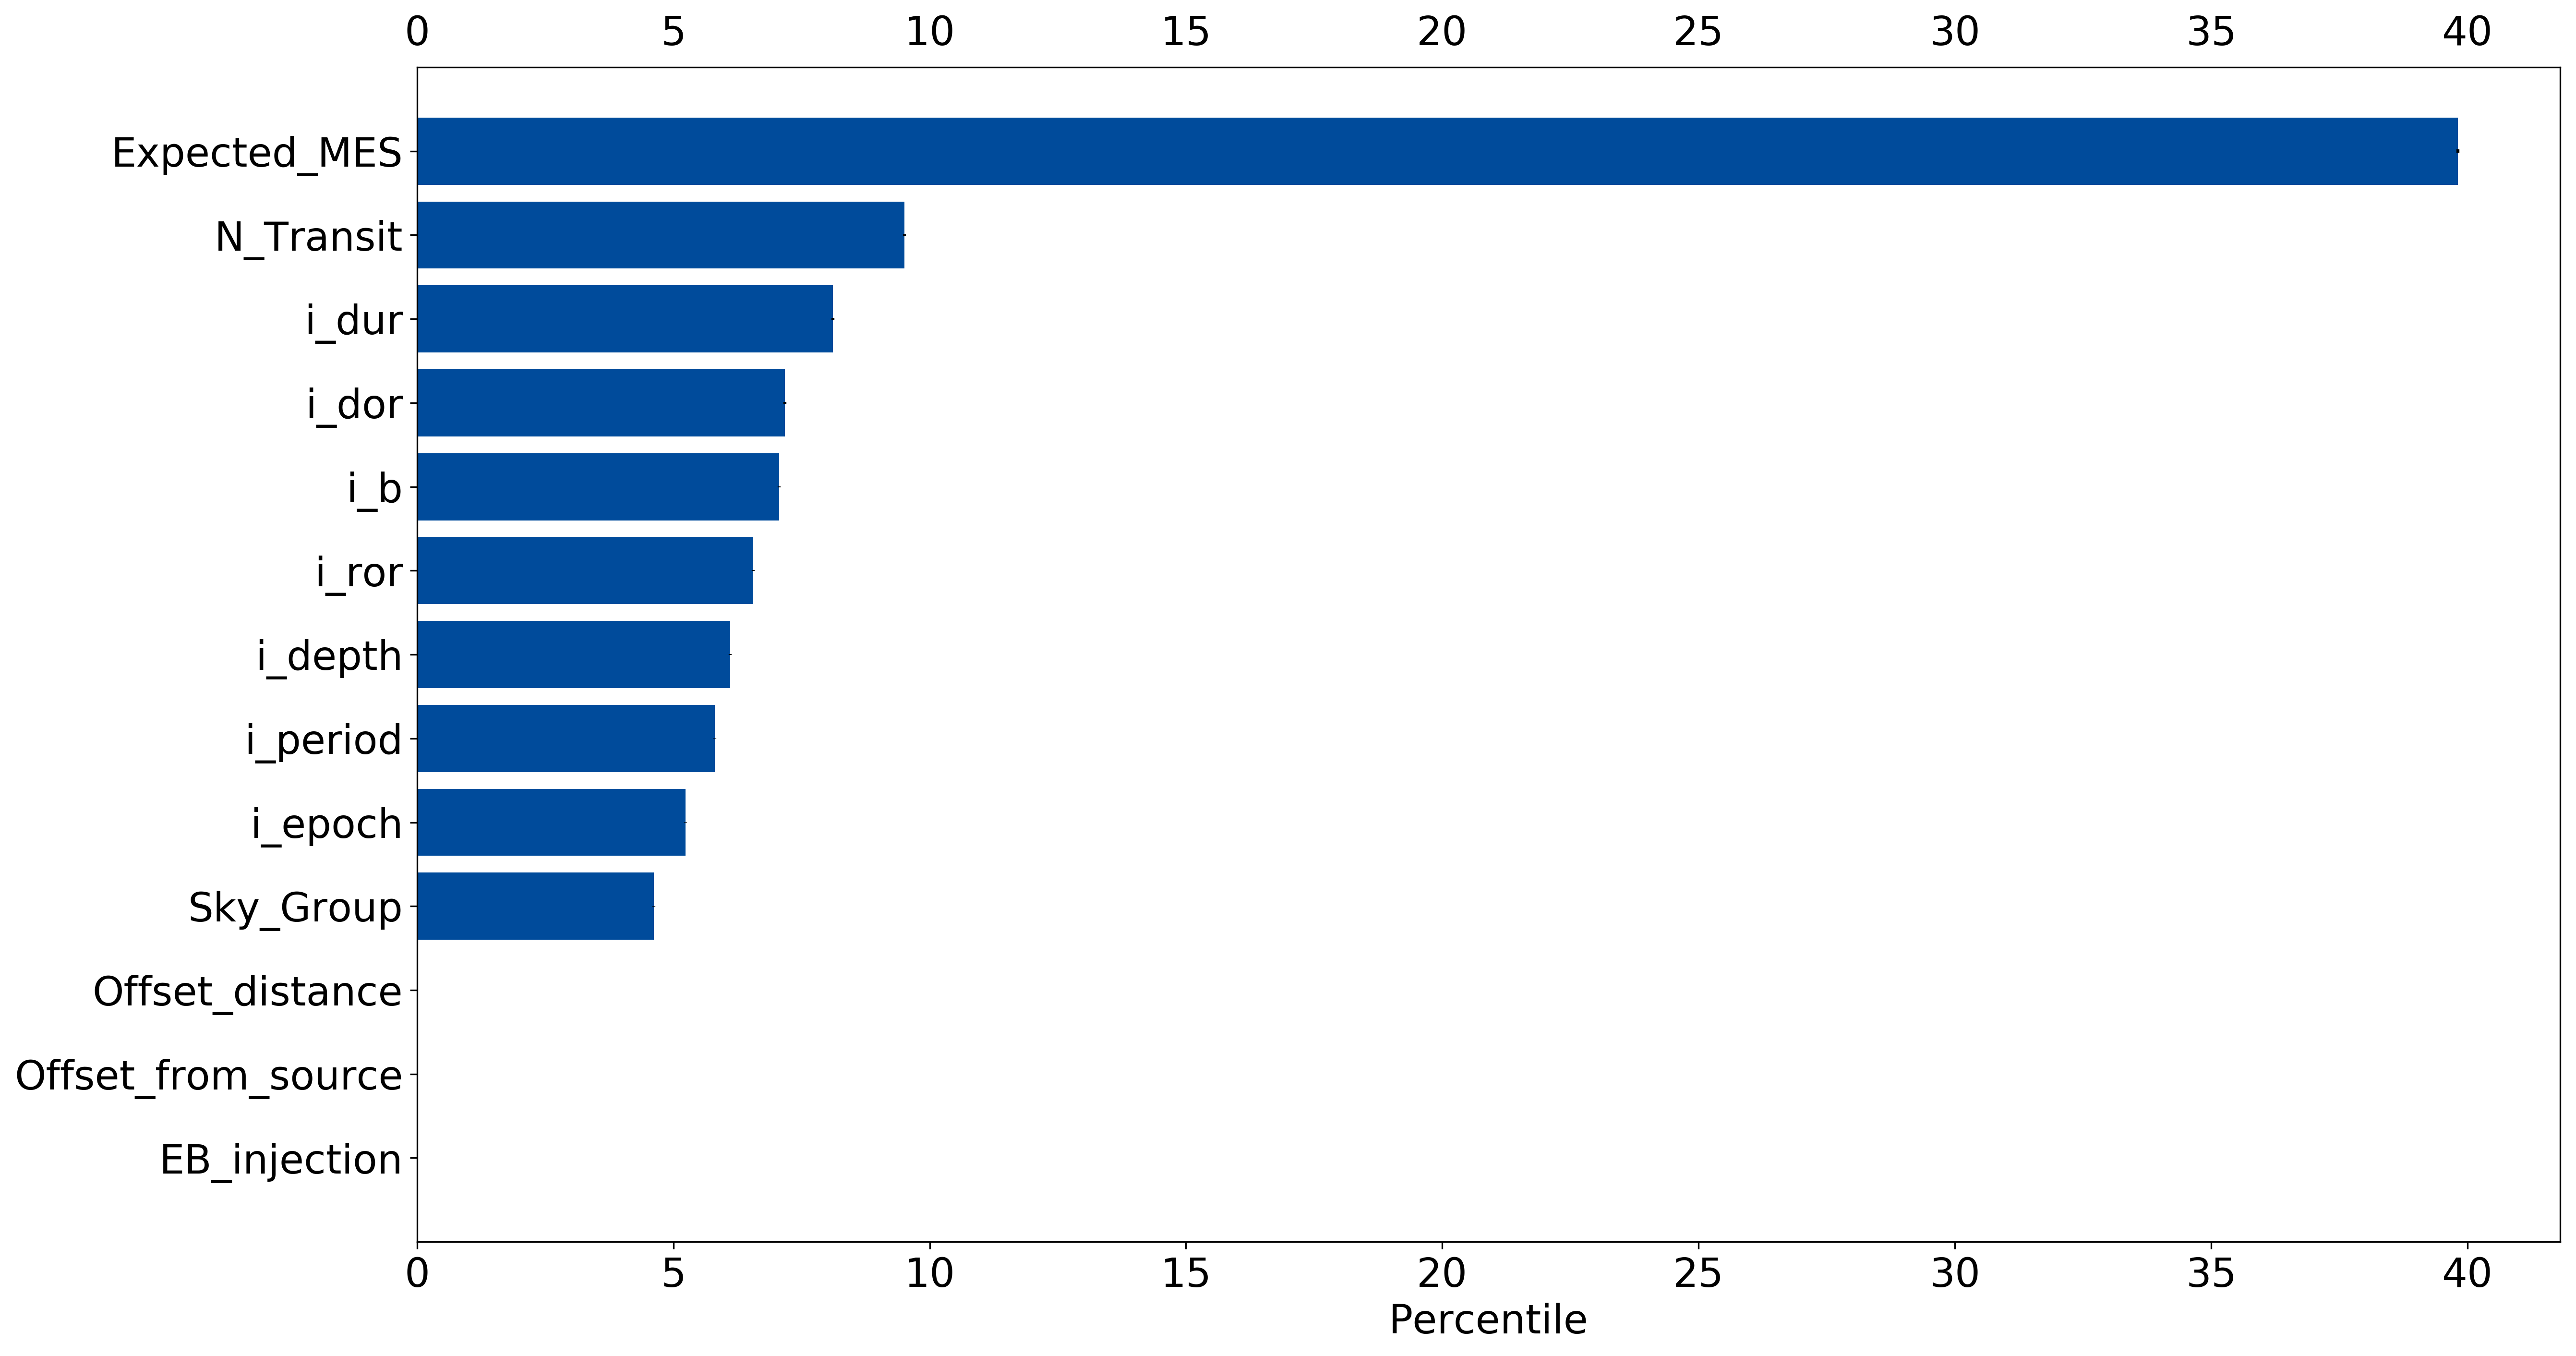

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot the feature importances of the forest
plt.figure(figsize = (19.20, 10.80), dpi = 300)
plt.tight_layout()
plt.barh(range(X.shape[1]), etc_importances[etc_indices]*100, color = '#004B9B', yerr=etc_std[etc_indices], align="center")

plt.yticks(range(X.shape[1]), etc_cols_indices, fontsize=20)
plt.ylim([X.shape[1], -1])

plt.tick_params(axis='x', labelbottom = True, labeltop = True)
plt.xticks(fontsize = 20)
plt.xlabel('Percentile', fontsize=20)

plt.savefig('full_dataset - extra_trees.jpg', dpi=1200, bbox_inches='tight')
plt.show()
plt.clf()

In [10]:
# Build a forest and compute the feature importances
rfc = RandomForestClassifier(n_jobs = -1, verbose = 1)

rfc.fit(X, Y)
rfc_importances = rfc.feature_importances_
rfc_std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis = 0)
rfc_indices = np.argsort(rfc_importances)[::-1]
rfc_cols_indices = cols_indices[rfc_indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, rfc_cols_indices[f], rfc_importances[rfc_indices[f]]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s


Feature ranking:
1. Expected_MES (0.466693)
2. i_dur (0.095839)
3. N_Transit (0.091029)
4. i_dor (0.061490)
5. i_b (0.060470)
6. i_ror (0.050874)
7. i_period (0.050122)
8. i_depth (0.048949)
9. i_epoch (0.041607)
10. Sky_Group (0.032927)
11. Offset_distance (0.000000)
12. Offset_from_source (0.000000)
13. EB_injection (0.000000)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


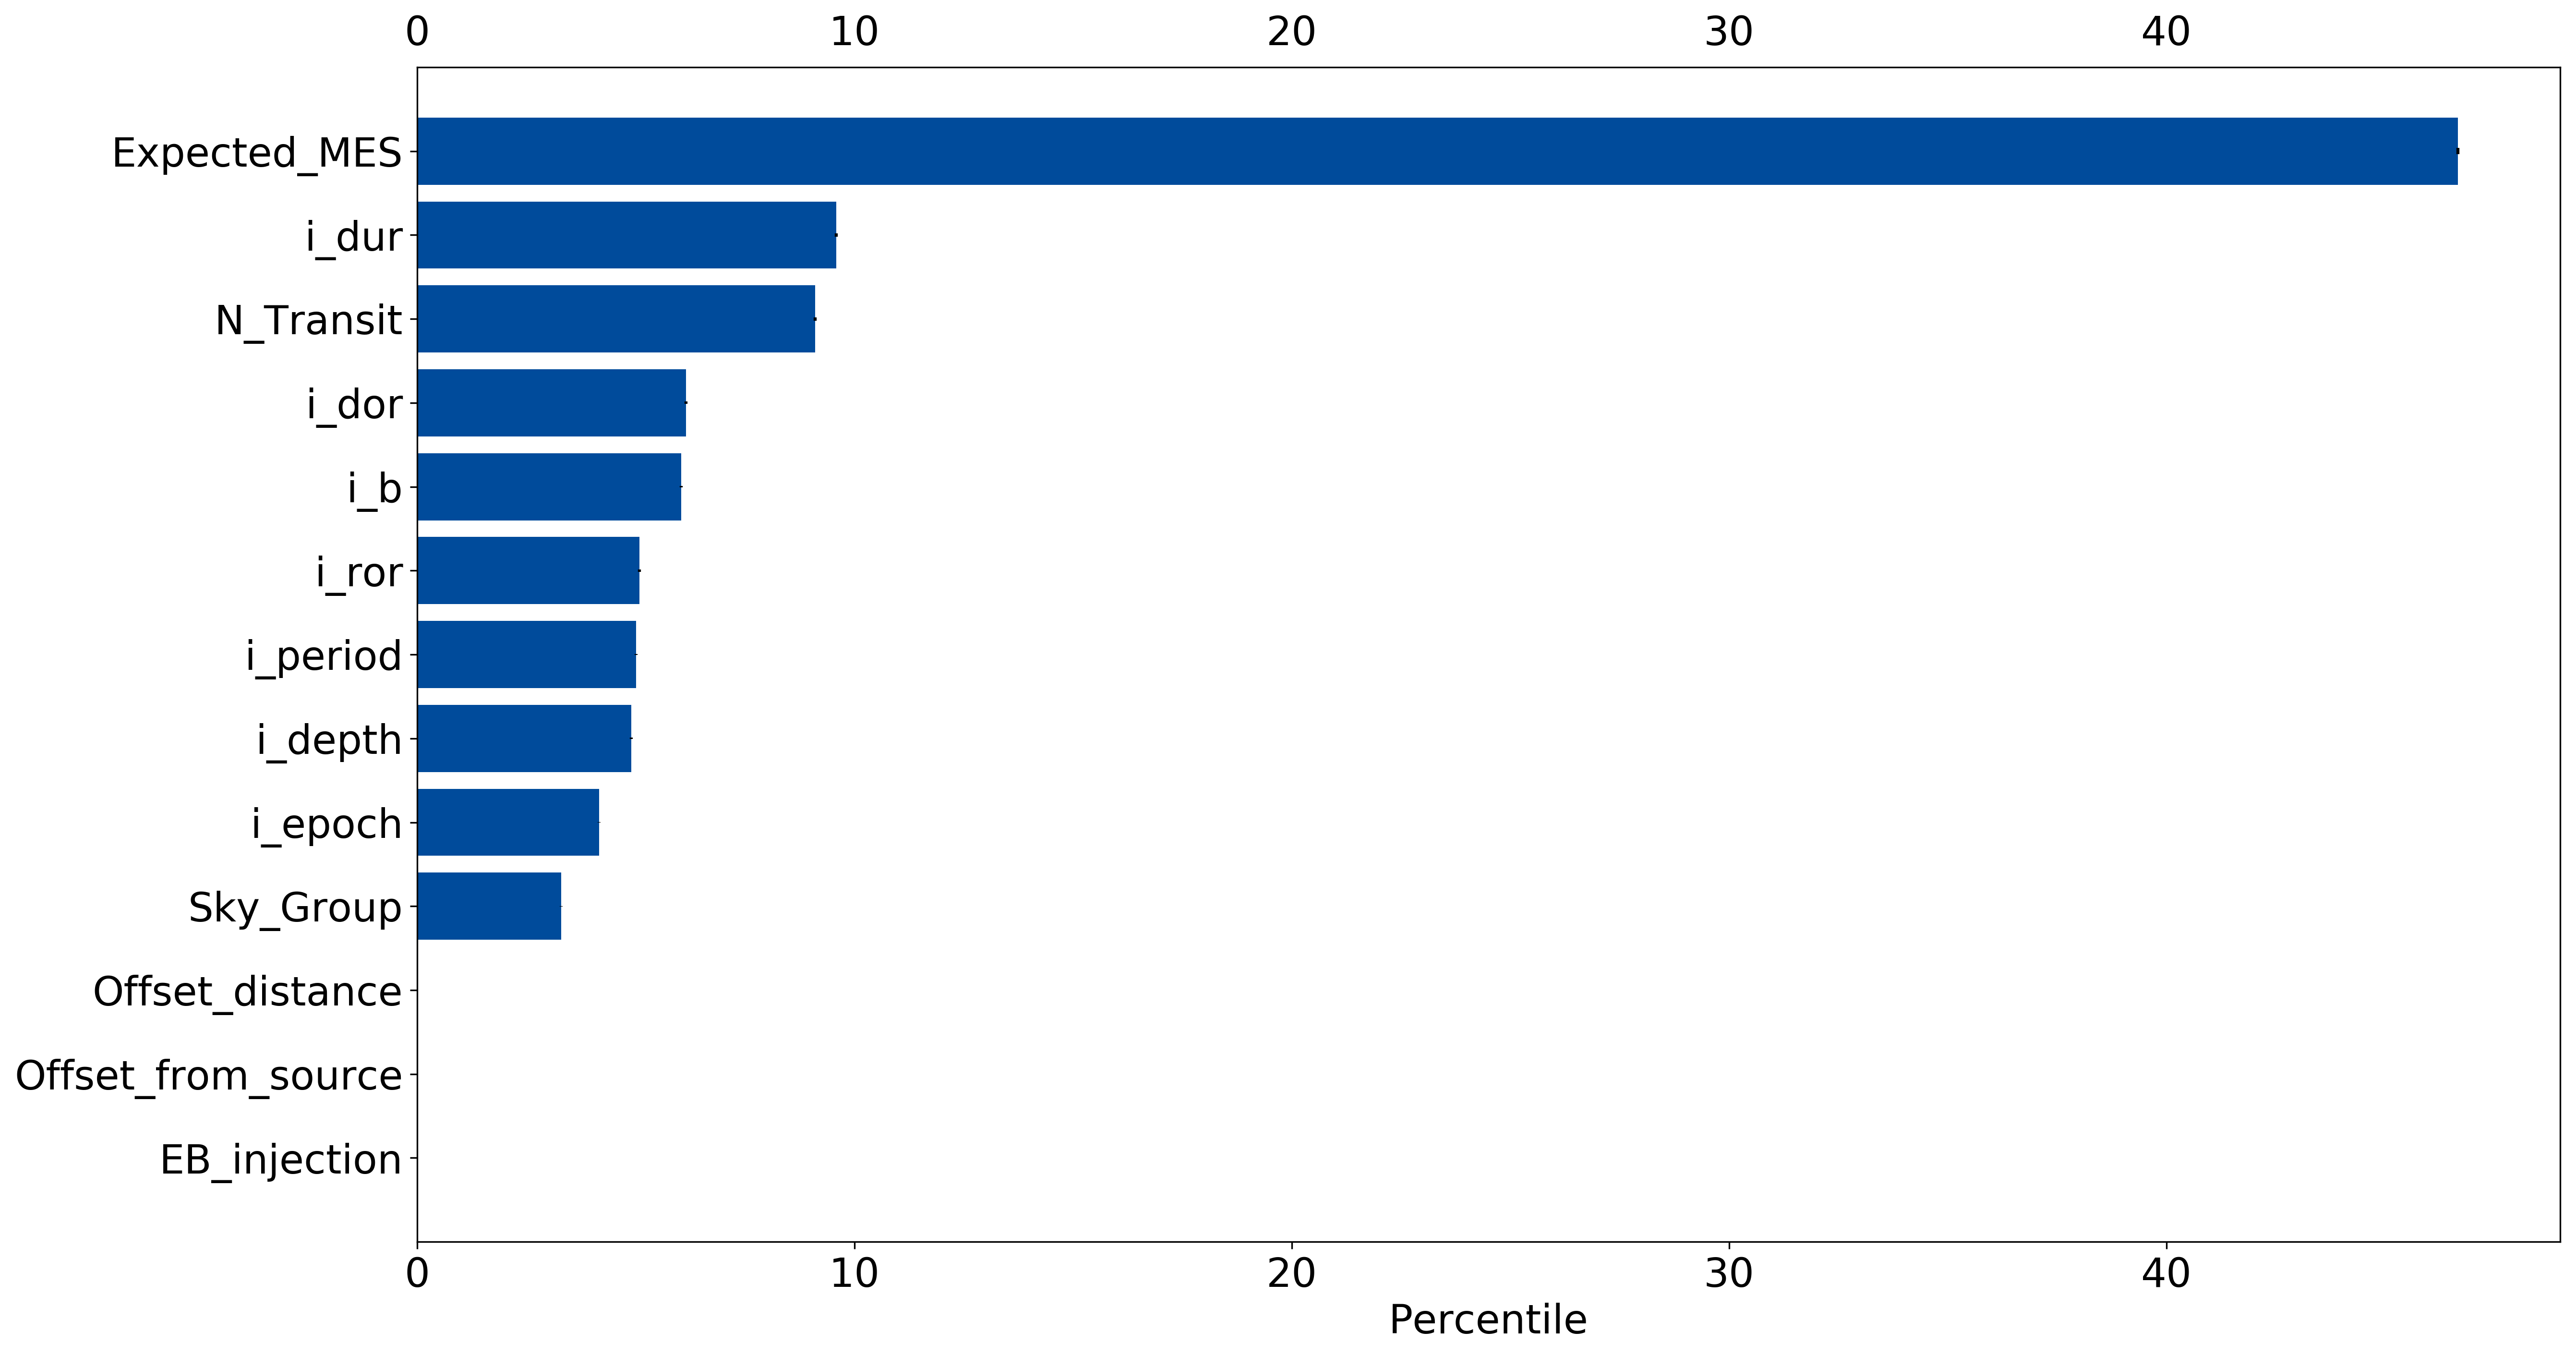

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the feature importances of the forest
plt.figure(figsize = (19.20, 10.80), dpi = 300)
plt.tight_layout()
plt.barh(range(X.shape[1]), rfc_importances[rfc_indices]*100, color = '#004B9B', yerr=rfc_std[rfc_indices], align="center")

plt.yticks(range(X.shape[1]), rfc_cols_indices, fontsize=20)
plt.ylim([X.shape[1], -1])

plt.tick_params(axis='x', labelbottom = True, labeltop = True)
plt.xticks(fontsize = 20)
plt.xlabel('Percentile', fontsize=20)

plt.savefig('full_dataset - random_forest.jpg', dpi=1200, bbox_inches='tight')
plt.show()
plt.clf()

In [12]:
# Build a forest and compute the feature importances
xgb = XGBClassifier(n_jobs = -1, verbose = 1)

xgb.fit(X, Y)
xgb_importances = xgb.feature_importances_
#xgb_std = np.std([tree.feature_importances_ for tree in xgb.estimators_], axis = 0)
xgb_indices = np.argsort(xgb_importances)[::-1]
xgb_cols_indices = cols_indices[xgb_indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, xgb_cols_indices[f], xgb_importances[xgb_indices[f]]))

Feature ranking:
1. Expected_MES (0.539944)
2. i_dur (0.238365)
3. N_Transit (0.124219)
4. i_ror (0.037393)
5. i_dor (0.024951)
6. i_b (0.018695)
7. i_depth (0.005316)
8. i_period (0.005289)
9. Sky_Group (0.004625)
10. i_epoch (0.001204)
11. Offset_distance (0.000000)
12. Offset_from_source (0.000000)
13. EB_injection (0.000000)


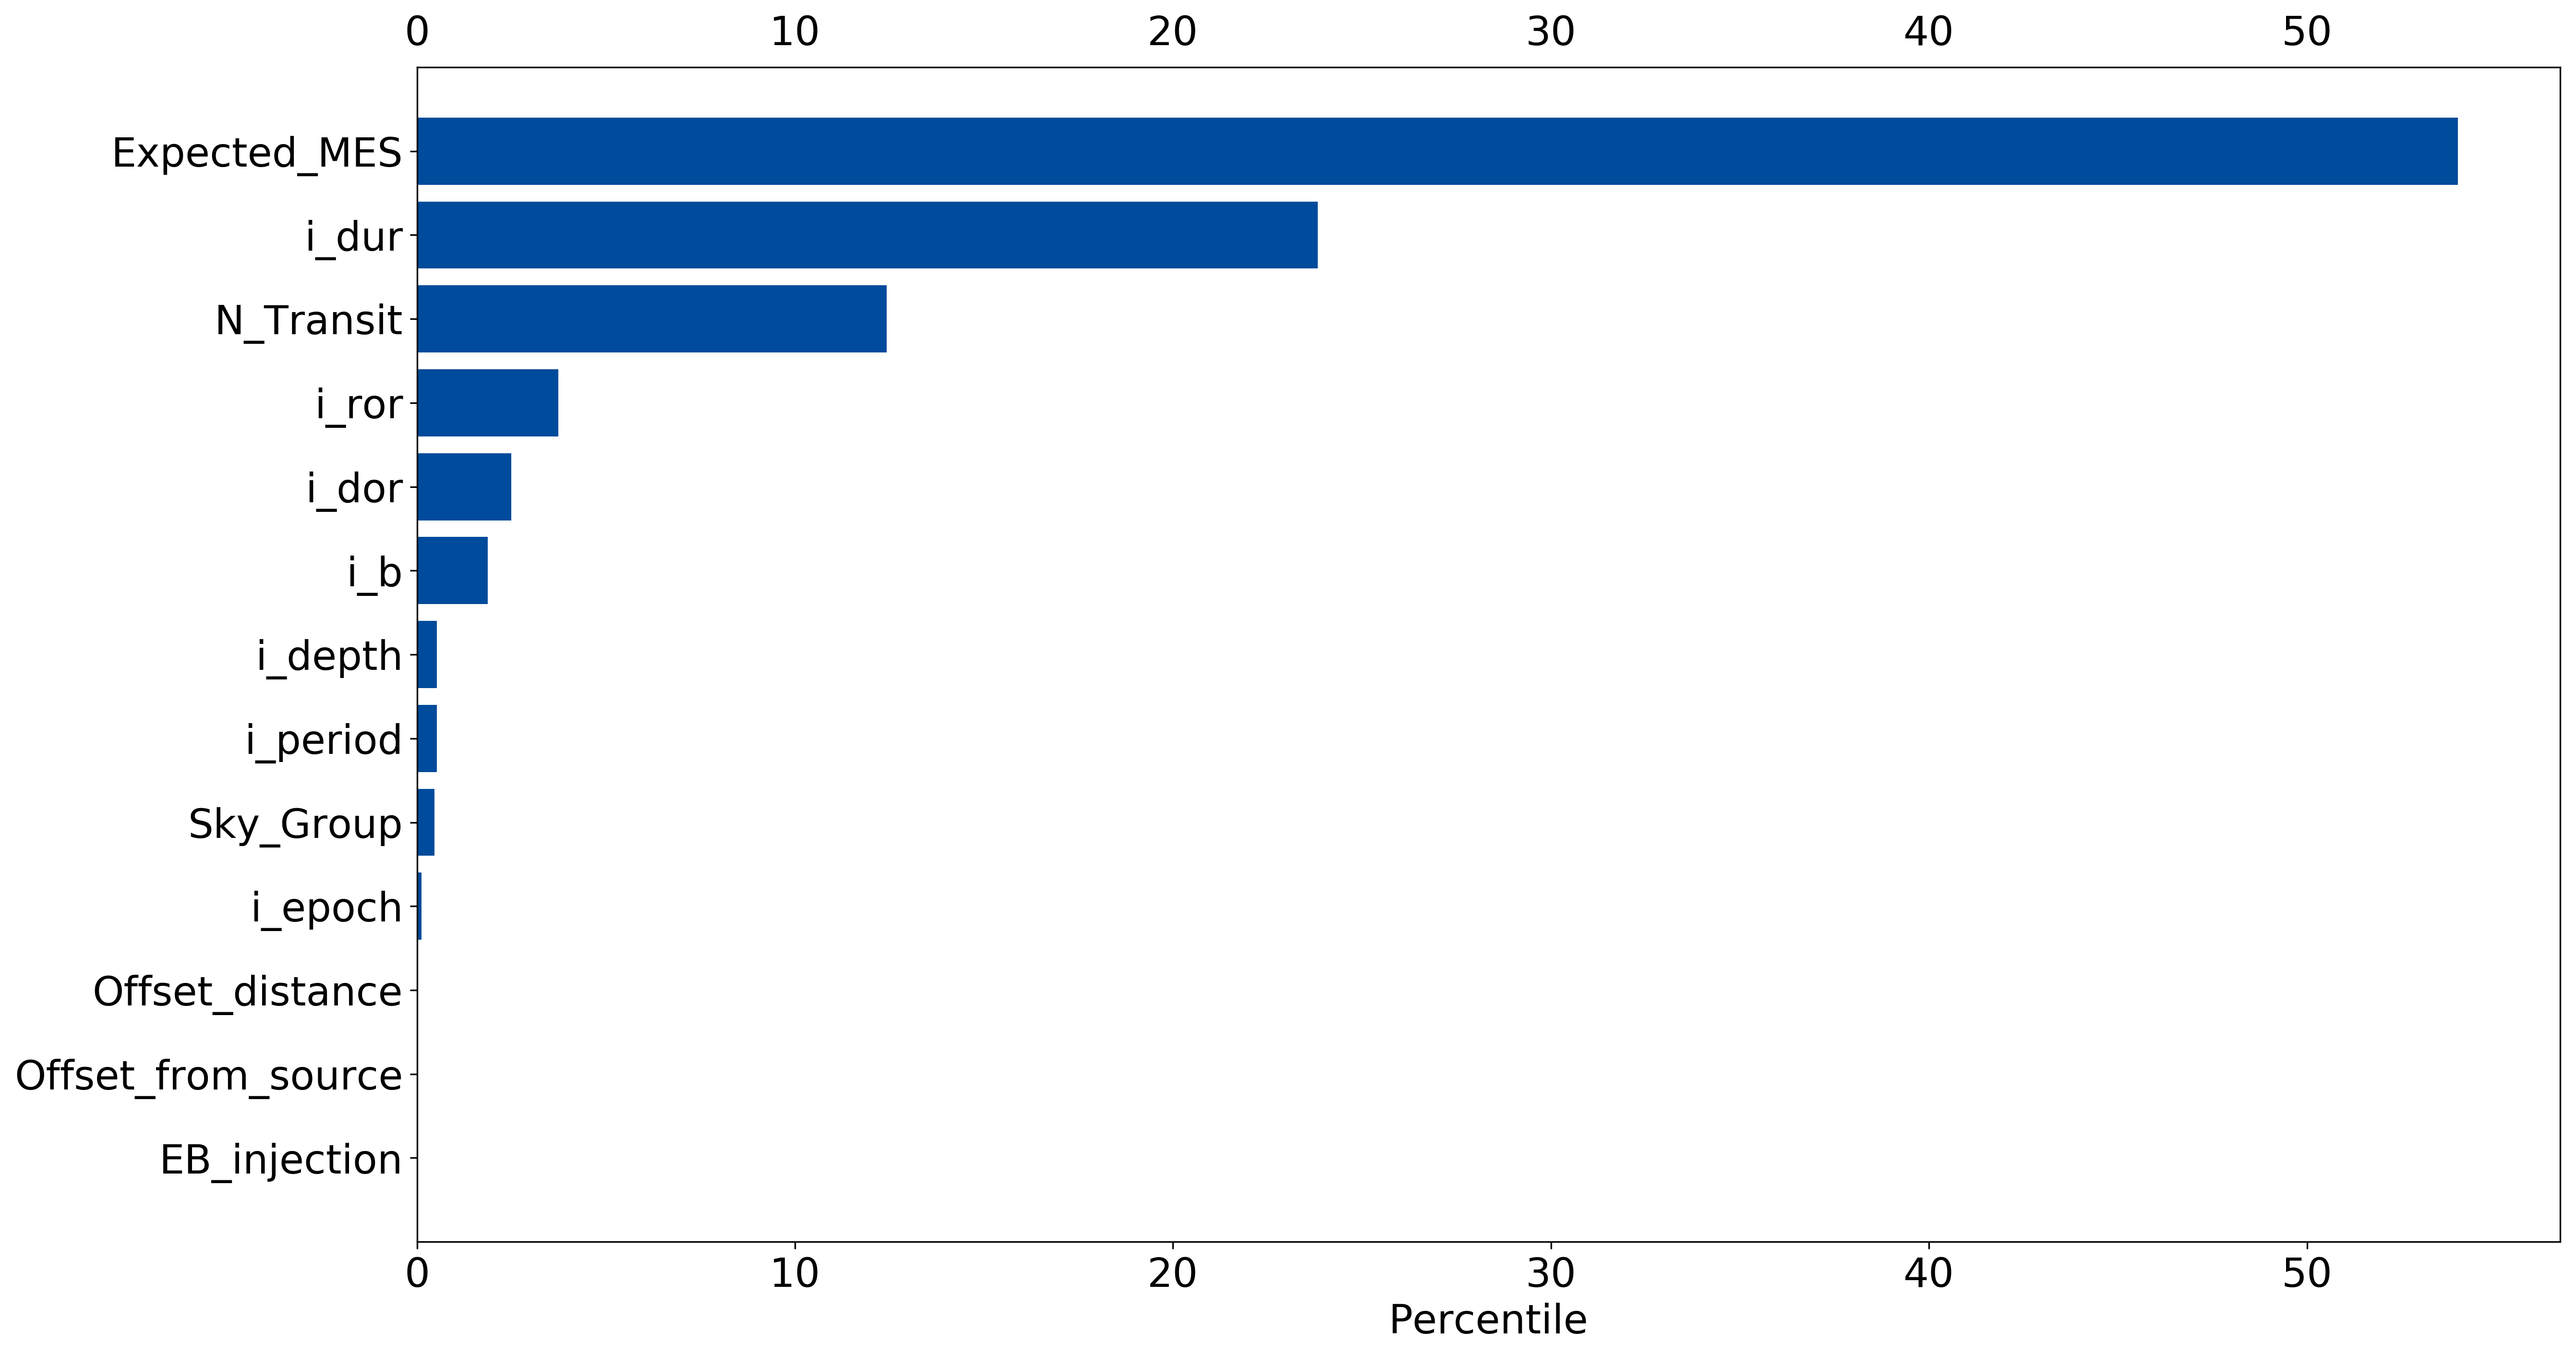

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the feature importances of the forest
plt.figure(figsize = (19.20, 10.80), dpi = 300)
plt.tight_layout()
plt.barh(range(X.shape[1]), xgb_importances[xgb_indices]*100, color = '#004B9B', align="center")

plt.yticks(range(X.shape[1]), xgb_cols_indices, fontsize=20)
plt.ylim([X.shape[1], -1])

plt.tick_params(axis='x', labelbottom = True, labeltop = True)
plt.xticks(fontsize = 20)
plt.xlabel('Percentile', fontsize=20)

plt.savefig('full_dataset - xgboost.jpg', dpi=1200, bbox_inches='tight')
plt.show()
plt.clf()

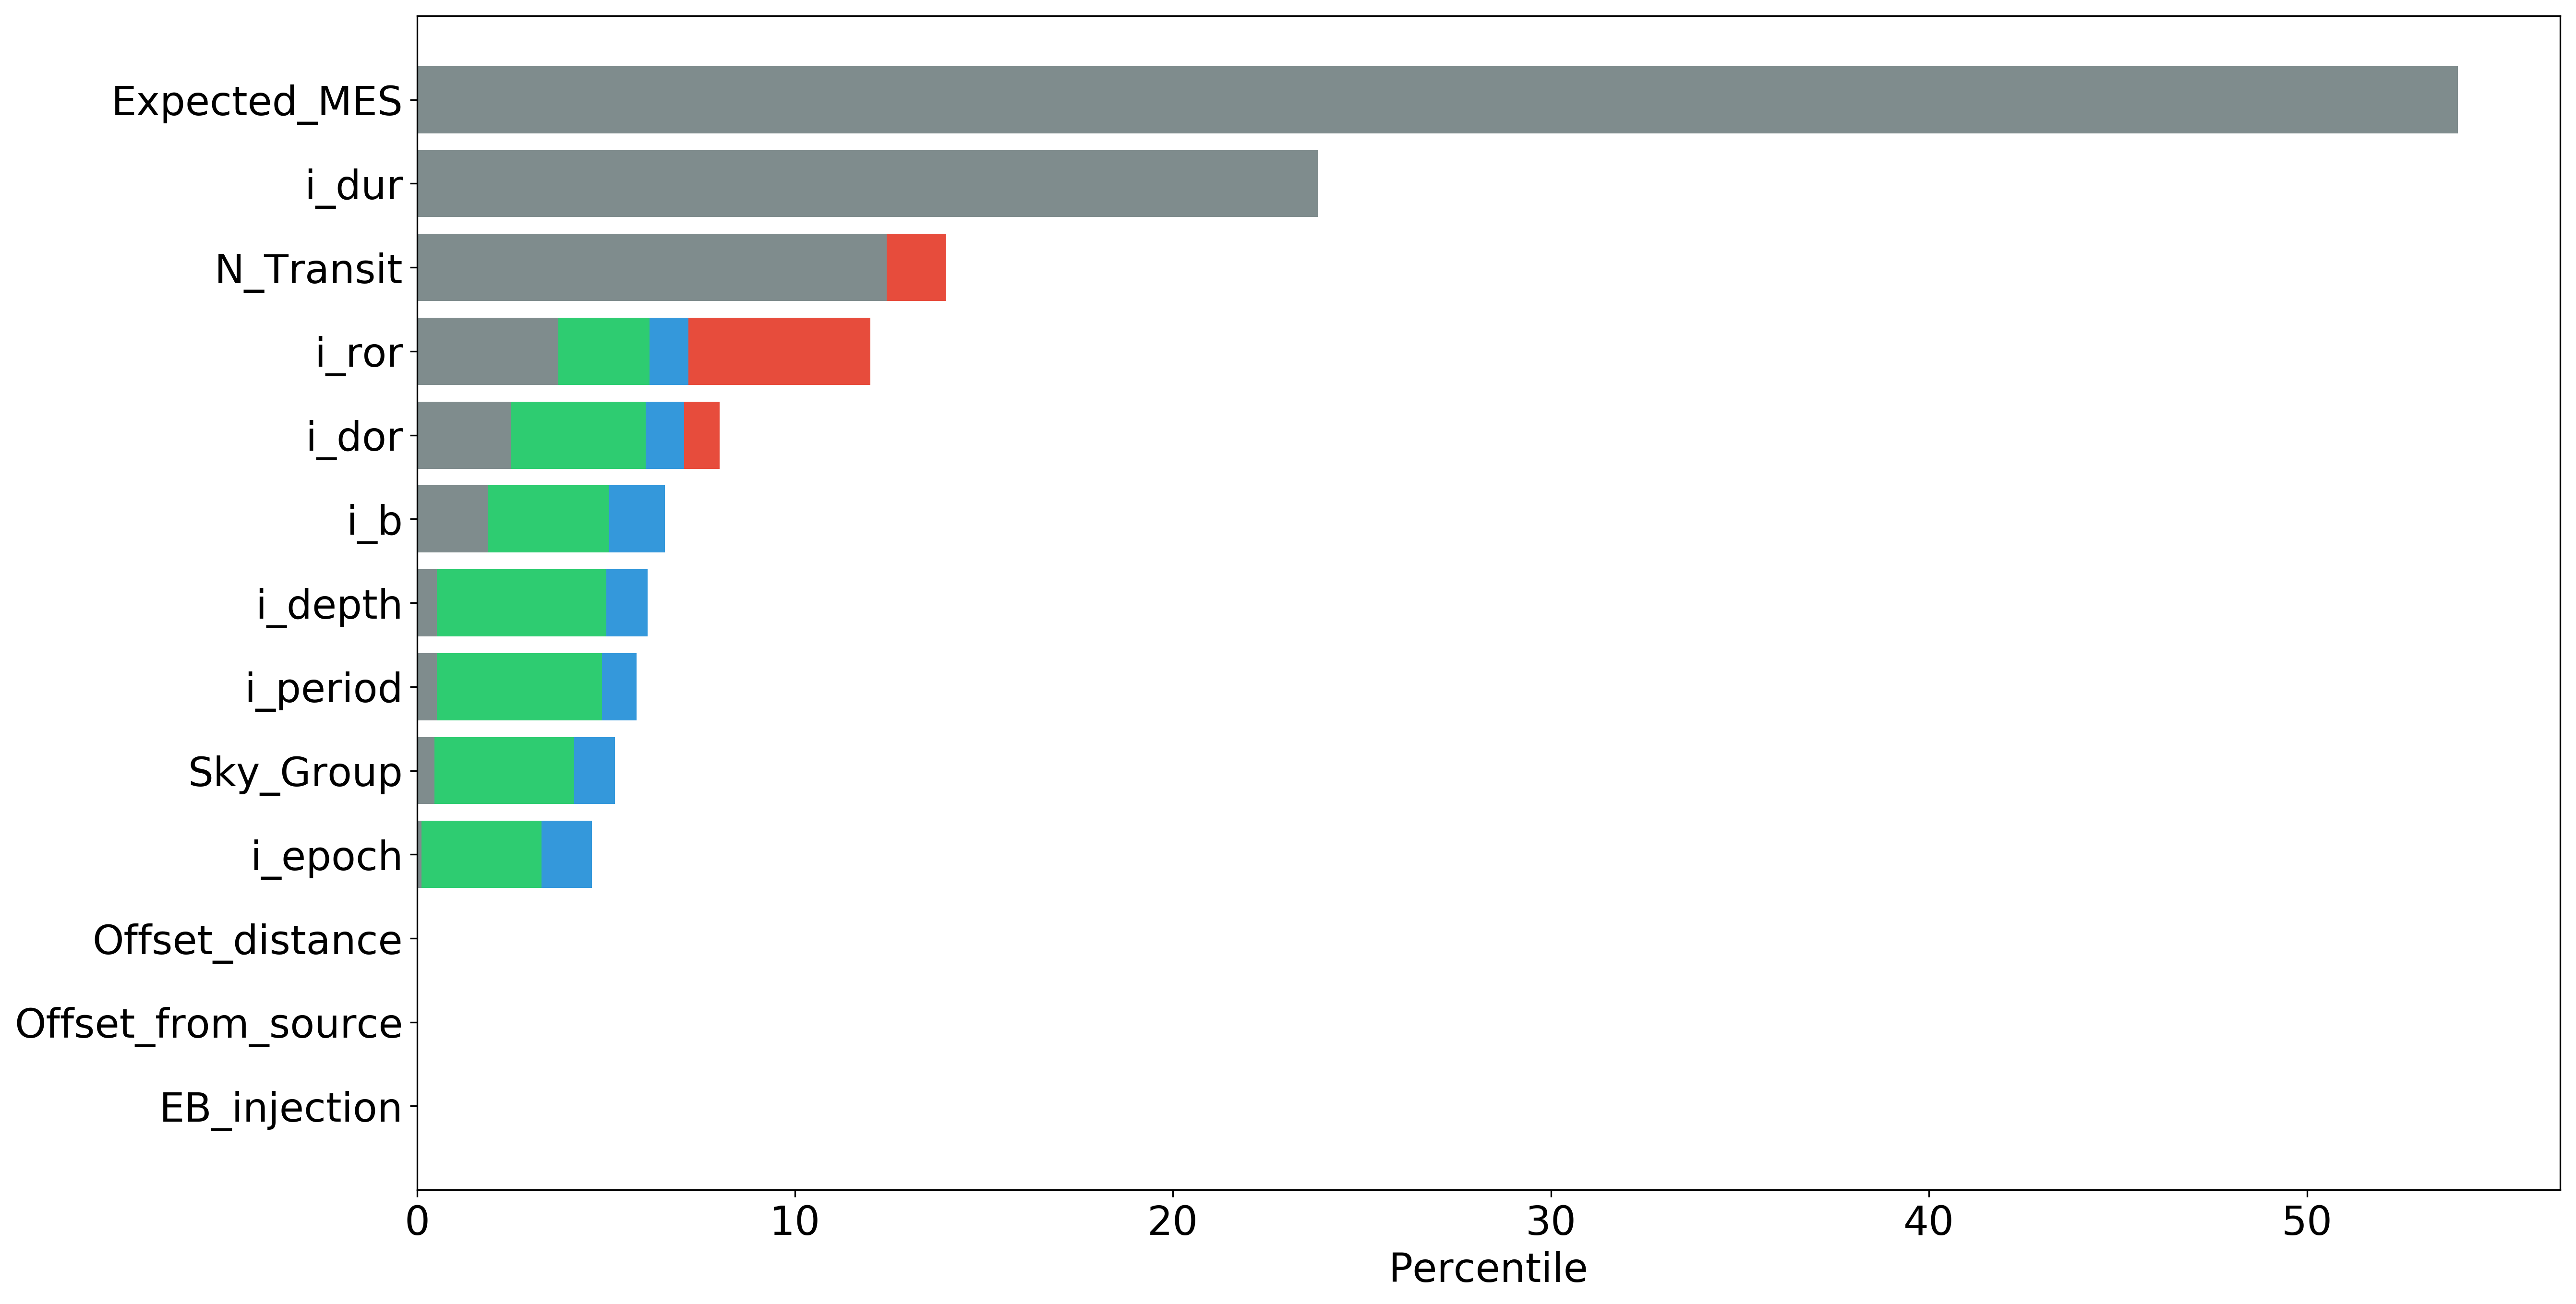

<Figure size 432x288 with 0 Axes>

In [14]:
# Plot all the plots together
plt.figure(figsize = (19.20, 10.80), dpi = 300)
plt.tight_layout()

plt.barh(range(X.shape[1]), abc_importances[abc_indices] * 100, color = '#E74C3C')
plt.barh(range(X.shape[1]), etc_importances[etc_indices] * 100, color = '#3498DB')
plt.barh(range(X.shape[1]), rfc_importances[rfc_indices] * 100, color = '#2ECC71')
plt.barh(range(X.shape[1]), xgb_importances[xgb_indices] * 100, color = '#7F8C8D')

plt.yticks(range(X.shape[1]), xgb_cols_indices, fontsize=20)
plt.ylim([X.shape[1], -1])

plt.xticks(fontsize = 20)
plt.xlabel('Percentile', fontsize=20)

plt.savefig('all_combined.jpg', dpi=1200, bbox_inches='tight')
plt.show()
plt.clf()